In [5]:
mnist = {}

mnist.path_remote = 'https://s3.amazonaws.com/torch7/data/mnist.t7.tgz'
mnist.path_dataset = 'mnist.t7'
mnist.path_trainset = paths.concat(mnist.path_dataset, 'train_32x32.t7')
mnist.path_testset = paths.concat(mnist.path_dataset, 'test_32x32.t7')

if not paths.filep(mnist.path_trainset) or not paths.filep(mnist.path_testset) then
  local remote = mnist.path_remote
  local tar = paths.basename(remote)
  os.execute('wget ' .. remote .. '; ' .. 'tar xvf ' .. tar .. '; rm ' .. tar)
end


trainset = torch.load(mnist.path_trainset, 'ascii')
testset = torch.load(mnist.path_testset, 'ascii')
rawTestset = torch.load(mnist.path_testset, 'ascii')

In [6]:
require 'cunn'

setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.labels[i]} 
                end}
);
trainset.data = trainset.data:double()
testset.data = testset.data:double()
rawTestset.data = rawTestset.data:double()

function trainset:size() 
    return self.data:size(1) 
end

In [7]:
mean = trainset.data:mean()
stdv = trainset.data:std()

trainset.data:add(-mean)
trainset.data:div(stdv)
trainset.data = trainset.data:cuda()
trainset.labels = trainset.labels:cuda()

testset.data:add(-mean)
testset.data:mul(1/stdv)
testset.data = testset.data:cuda()
testset.labels = trainset.labels:cuda()

rawTestset.data = testset.data:cuda()
rawTestset.labels = trainset.labels:cuda()

In [13]:
import 'nn'

-- net = torch.load('model.t7')

net = nn.Sequential()
net:add(nn.SpatialConvolution(1,6,5,5))
net:add(nn.ReLU())
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.SpatialConvolution(6,16,5,5))
net:add(nn.ReLU())
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))
net:add(nn.Linear(16*5*5, 120))
net:add(nn.ReLU())
net:add(nn.Linear(120,84))
net:add(nn.ReLU())
net:add(nn.Linear(84,10))
net:add(nn.LogSoftMax())

net = net:cuda()

print('LeNet5\n' .. net:__tostring())

LeNet5
nn.Sequential {
  [input -> (1) -> (2) -> (3) -> (4) -> (5) -> (6) -> (7) -> (8) -> (9) -> (10) -> (11) -> (12) -> (13) -> output]
  (1): nn.SpatialConvolution(1 -> 6, 5x5)
  (2): nn.ReLU
  (3): nn.SpatialMaxPooling(2x2, 2,2)
  (4): nn.SpatialConvolution(6 -> 16, 5x5)
  (5): nn.ReLU
  (6): nn.SpatialMaxPooling(2x2, 2,2)
  (7): nn.View(400)
  (8): nn.Linear(400 -> 120)
  (9): nn.ReLU
  (10): nn.Linear(120 -> 84)
  (11): nn.ReLU
  (12): nn.Linear(84 -> 10)
  (13): nn.LogSoftMax
}	


In [ ]:
criterion = nn.ClassNLLCriterion()
criterion = criterion:cuda()

In [ ]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5

In [ ]:
trainer:train(trainset)

In [ ]:
classes = {0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [ ]:
correct = 0
for i=1,testset.data:size(1) do
    local groundtruth = testset.labels[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end

In [ ]:
print(correct, 100*correct/testset.data:size(1) .. '%')

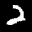

 1.0416e-08
 2.5838e-07
 1.0000e+00
 5.9992e-07
 8.7371e-11
 1.0413e-11
 1.1487e-12
 9.9298e-07
 2.1944e-08
 2.1698e-12
[torch.CudaTensor of size 10]



In [12]:
s = torch.random() % 10000
file = torch.DiskFile("pic.png", "w")
itorch.image(testset.data[s])

inputFile = torch.DiskFile("input.dat", "w")
for i=1,32 do
    for j=1,32 do
        inputFile:writeFloat(rawTestset.data[s][1][i][j])
    end
end
inputFile:close()

predict = net:forward(testset.data[s])
print(torch.exp(predict))
outputFile = torch.DiskFile("out.gold.dat", "w")
for i=1,10 do
    outputFile:writeFloat(torch.exp(predict[i]))
end
outputFile:close()